# DeepDive on liver subset of sci-ATAC-seq3

## Imports

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import snapatac2
import DeepDive

In [2]:
import sys
sys.path.insert(0, "../utils")

In [3]:
from utils import reads_to_fragments, plot_marker_heatmap, subet_markers, set_dropout, get_dense_matrix, w_dimred, plot_embedding_joint, mse

## Loading and preprocessing data

In [4]:
# From https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4508935
adata = sc.read_h5ad('../data/GSM4508935_liver_filtered.h5ad')

adata

AnnData object with n_obs × n_vars = 183175 × 1050819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type'
    var: 'x'

In [5]:
adata.var_names = adata.var_names.map(lambda x: '{}:{}-{}'.format(*x.split('-')))

In [6]:
discrete_covriate_keys = ['sample_name', 'sex', 'batch', 'cell_type']
continuous_covriate_keys = ['day_of_pregnancy']

In [7]:
adata.obs_names_make_unique()
adata = reads_to_fragments(adata, copy = True)

min_cells = int(adata.shape[0] * 0.02)
sc.pp.filter_genes(adata, min_cells=min_cells)


In [8]:
adata

AnnData object with n_obs × n_vars = 183175 × 13178
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type'
    var: 'x', 'n_cells'

## Find cell type markers

In [9]:
markers = snapatac2.tl.marker_regions(adata, groupby='cell_type')

In [10]:
snapatac2.pp.select_features(adata, n_features=13178)

2025-10-13 07:56:43 - INFO - Selected 13048 features.


In [11]:
markers_subset = subet_markers(markers, 10)

In [12]:
for_plot = adata.copy()

In [13]:
sc.pp.normalize_total(for_plot)

## Train DeepDive

In [14]:
n_decoders = 1
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
}

In [15]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [16]:
model_path = f'../models/F1_liver/F1_liver_model_1.pt'

In [17]:
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
else:
    
    model.train_model(adata, None, 
                  **train_params)
    torch.save(model.state_dict(), model_path)

In [18]:
set_dropout(model)

## Reconstructing accessibility

In [19]:
rec = model.predict(adata, library_size = 10_000)

In [20]:
recon_sub = sc.pp.subsample(rec, n_obs=10000, copy=True)
real_sub = adata[recon_sub.obs_names]
sc.pp.normalize_total(real_sub, target_sum = 10_000)


In [21]:
# Per cell MSE
P_real = get_dense_matrix(real_sub, max_features=None)
P_recon = get_dense_matrix(recon_sub, max_features=None)

n_cells = P_real.shape[0]
mse_cellwise = np.mean((P_real - P_recon)**2, axis=1)
rng = np.random.default_rng(seed=42)
mse_random = np.zeros(n_cells)
for i in range(n_cells):
    j = rng.integers(low=0, high=n_cells-1)
    while j == i:
        j = rng.integers(low=0, high=n_cells-1)
    mse_random[i] = np.mean((P_real[i] - P_real[j])**2)

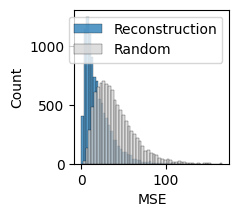

In [22]:
plt.subplots(figsize=(2,2))
sns.histplot(mse_cellwise, label = 'Reconstruction', bins = 50)
sns.histplot(mse_random, label = 'Random', bins = 50, color = 'lightgray')
plt.legend()
plt.xlabel('MSE')
plt.savefig('../figures/S1E.pdf')

In [23]:
rec = model.predict(adata, library_size = 10_000, covars_to_add = ['cell_type'], batch_size = 256)

In [24]:
rec_all = model.predict(adata, library_size = 10_000, covars_to_add = None, batch_size = 256)

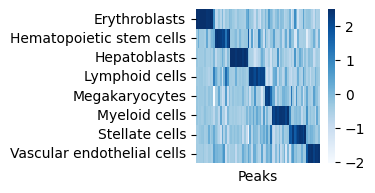

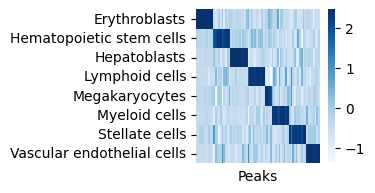

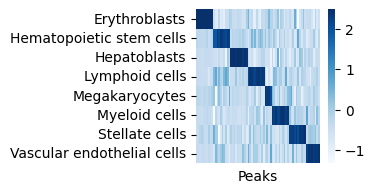

In [25]:
plot_marker_heatmap(for_plot, markers_subset)
plt.savefig('../figures/F1B_top.pdf')

plot_marker_heatmap(rec, markers_subset)
plt.savefig('../figures/F1B_bottom.pdf')

plot_marker_heatmap(rec_all, markers_subset)
plt.savefig('../figures/S1A.pdf')

## Plot covariate embeddings

In [26]:
embeddings = {x:y.weight.detach().cpu().numpy() for x, y in model.known.discrete_covariates_embeddings.items()}

In [27]:
key_list = list(embeddings.keys())
ls_n_features = [embeddings[key].shape[0] -1 for key in key_list]

In [28]:
weights = [1-(x/sum(ls_n_features)) for x in ls_n_features]
weights = {x:y for x,y in zip(key_list, weights)}

In [29]:
out = []
for x, y in embeddings.items():
    tmp = pd.DataFrame(y[:-1], index = model.data_register['covariate_names_unique'][x][:-1])
    tmp['group'] = x
    out.append(tmp)

In [30]:
# Needs scipy==1.13.1

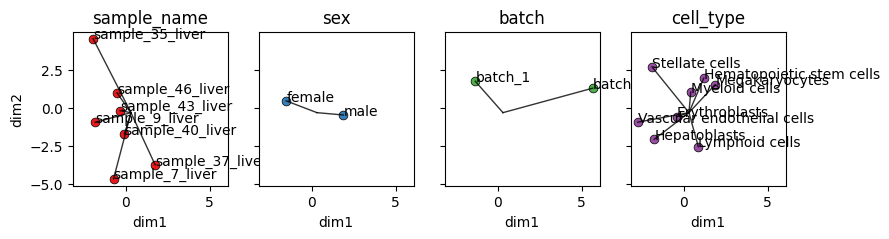

In [31]:
emb = pd.concat(out)
plot_embedding_joint(emb, weights=weights)
plt.savefig('../figures/S1B.pdf', transparent = True)

## DA overlap in reconstruciton

In [32]:
for_da = adata.copy()

In [33]:
markers_gt = snapatac2.tl.marker_regions(for_da, groupby='cell_type', pvalue = 0.05)
markers_rec = snapatac2.tl.marker_regions(rec, groupby='cell_type', pvalue = 0.05)
markers_rec_all = snapatac2.tl.marker_regions(rec_all, groupby='cell_type', pvalue = 0.05)

In [34]:
marker_gt_n = {x: len(y) for x, y in markers_gt.items()}
marker_rec_n = {x: len(y) for x, y in markers_rec.items()}
marker_rec_all_n = {x: len(y) for x, y in markers_rec_all.items()}

In [35]:
n = pd.DataFrame([marker_gt_n, marker_rec_n, marker_rec_all_n], index = ['Raw', 'Cell type', 'All covars']).T

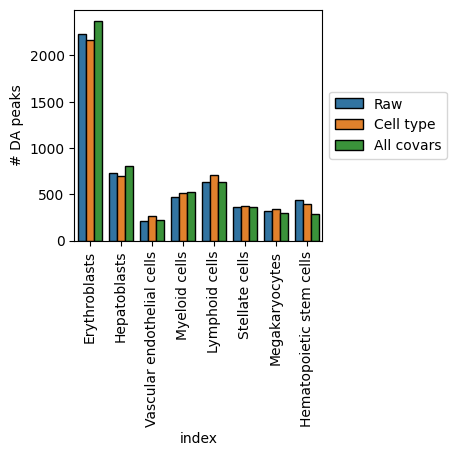

In [36]:
fig, ax = plt.subplots(figsize = (4,3))
sns.barplot(n.reset_index().melt( id_vars=["index"]), x = 'index', y = 'value', hue = 'variable',
            edgecolor = 'k', order = adata.obs.cell_type.value_counts().index)
plt.ylabel('# DA peaks')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.savefig('../figures/S1C.pdf', transparent = True)

In [37]:
overlap = {}
for i in adata.obs.cell_type.unique():
    gt = set(markers_gt[i])
    r = set(markers_rec[i])
    ra = set(markers_rec_all[i])
    gt_r = len(gt.intersection(r)) / len(gt)
    gt_ra = len(gt.intersection(ra)) / len(gt)
    overlap[i] = [gt_r, gt_ra]
overlap = pd.DataFrame(overlap, index = ['Cell type', 'All covars'])

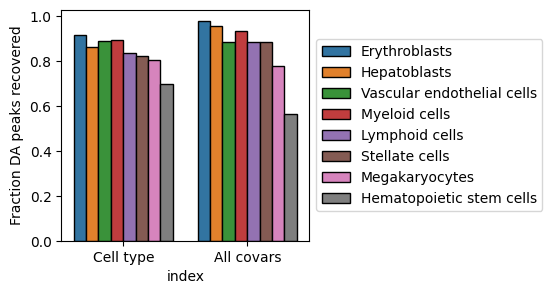

In [38]:
fig, ax = plt.subplots(figsize = (4,3))
sns.barplot(overlap.reset_index().melt( id_vars=["index"]), x = 'index', y = 'value', hue = 'variable', 
            hue_order = adata.obs.cell_type.value_counts().index, edgecolor = 'k')
plt.ylabel('Fraction DA peaks recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../figures/S1D.pdf', transparent = True)

## Multi decoder

In [39]:
rec_1_decoder = model.predict(adata)
mse_1_decoder = mse(adata.X.todense(), rec_1_decoder.X)

In [40]:
n_decoders = 5
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
}
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )
model_path = f'../models/F1_liver/S1F_liver_model_5.pt'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
else:
    
    model.train_model(adata, None, 
                  **train_params)
    torch.save(model.state_dict(), model_path)



In [41]:
rec_5_decoder = model.predict(adata)
mse_5_decoder = mse(adata.X.todense(), rec_5_decoder.X)


In [42]:
n_decoders = 20
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
}
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

model_path = f'../models/F1_liver/S1F_liver_model_20.pt'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
else:
    
    model.train_model(adata, None, 
                  **train_params)
    torch.save(model.state_dict(), model_path)

In [43]:
rec_20_decoder = model.predict(adata)
mse_20_decoder = mse(adata.X.todense(), rec_20_decoder.X)


2025-10-13 07:58:57 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-13 07:58:57 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


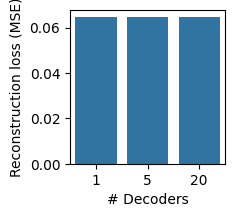

In [44]:
plt.subplots(figsize=(2,2))
sns.barplot(x = [1,5, 20], y = [mse_1_decoder, mse_5_decoder, mse_20_decoder, ])

plt.ylabel('Reconstruction loss (MSE)')
plt.xlabel('# Decoders')
plt.savefig('../figures/S1F.pdf')

2025-10-13 07:58:57 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-13 07:58:57 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


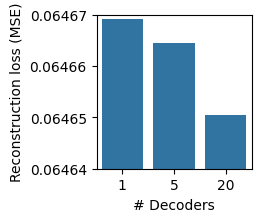

In [45]:
plt.subplots(figsize=(2,2))
sns.barplot(x = [1,5, 20], y = [mse_1_decoder, mse_5_decoder, mse_20_decoder, ])

plt.ylabel('Reconstruction loss (MSE)')
plt.xlabel('# Decoders')
plt.ylim(0.06464, 0.06467)
plt.savefig('../figures/S1F_crop.pdf')